In [232]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score
import xgboost as xgb
import lightgbm as lgb
import re
import optuna

In [233]:
pd.set_option('display.max_columns', None)

In [234]:
train_df = pd.read_csv('data/train.csv')
train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [235]:
test_df = pd.read_csv('data/test.csv')
test_df.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# EDA

In [236]:
train_df[['Survived', 'Embarked']].groupby('Embarked').mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


# Feature Engineering

In [237]:
train_df['Sex'] = train_df['Sex'].map({'male' : 0, 'female' : 1})
test_df['Sex'] = test_df['Sex'].map({'male' : 0, 'female' : 1})

In [238]:

train_df['Title'] = train_df['Name'].str.extract(r'(Mr\.|Mrs\.|Ms\.|Miss|Dr\.|Rev\.)')
test_df['Title'] = test_df['Name'].str.extract(r'(Mr\.|Mrs\.|Ms\.|Miss|Dr\.|Rev\.)')

train_df = pd.get_dummies(train_df, columns = ['Title'])
test_df = pd.get_dummies(test_df, columns = ['Title'])


In [239]:
train_df = pd.get_dummies(train_df, columns = ['Embarked'])
test_df = pd.get_dummies(test_df, columns = ['Embarked'])

In [240]:
title_one_hot = [col for col in train_df.columns if col.startswith('Title_')]
title_one_hot

['Title_Dr.',
 'Title_Miss',
 'Title_Mr.',
 'Title_Mrs.',
 'Title_Ms.',
 'Title_Rev.']

In [241]:
embarked_one_hot = [col for col in train_df.columns if col.startswith('Embarked_')]
embarked_one_hot

['Embarked_C', 'Embarked_Q', 'Embarked_S']

In [242]:
train_df['Is_Baby'] = train_df['Age'] <= 3
test_df['Is_Baby'] = test_df['Age'] <= 3

## Age Imputation

In [243]:
def impute_age(df):

   
    assert df['Age'].isnull().sum() > 0, 'No null values'
    age_df = df.copy()

    age_known = age_df[age_df['Age'].notnull()]
    age_missing = age_df[age_df['Age'].isnull()]

    features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare'] + title_one_hot + embarked_one_hot


    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 10, None],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    
    grid = GridSearchCV(
        estimator = RandomForestRegressor(random_state=0),
        param_grid=param_grid,
        cv = 5,
        scoring = 'neg_root_mean_squared_error',
        n_jobs = -1,
        verbose = 1
    )

    X_train = age_known[features]
    y_train = age_known['Age']


    X_pred = age_missing[features]


    grid.fit(X_train, y_train)

    print("Best Params:", grid.best_params_)
    print("Best RMSE:", -grid.best_score_)
    model = grid.best_estimator_

    age_df.loc[age_df['Age'].isnull(), 'Age'] = model.predict(X_pred)
    return age_df['Age']

In [244]:
train_df['Age Missing'] = train_df['Age'].isnull().astype(int)
test_df['Age Missing'] = test_df['Age'].isnull().astype(int)

In [245]:
train_df['Age'] = impute_age(train_df)
test_df['Age'] = impute_age(test_df)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100}
Best RMSE: 11.42709828995032
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Params: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best RMSE: 10.910272395209523


## Fare Imputation

In [246]:
train_df.loc[train_df['Fare'] == 0, 'Fare'] = np.nan
test_df.loc[test_df['Fare'] == 0, 'Fare'] = np.nan

In [247]:
def impute_fare(df):

    assert df['Fare'].isnull().sum() > 0, 'No null values'
    fare_df = df.copy()

    fare_known = fare_df[fare_df['Fare'].notnull()]
    fare_missing = fare_df[fare_df['Fare'].isnull()]

    features = ['Pclass', 'Sex', 'SibSp', 'Parch', 'Fare'] + title_one_hot + embarked_one_hot 

    X_train = fare_known[features]
    y_train = fare_known['Fare']


    X_pred = fare_missing[features]


    model = RandomForestRegressor(n_estimators = 100, random_state = 0)

    model.fit(X_train, y_train)

    fare_df.loc[fare_df['Fare'].isnull(), 'Fare'] = model.predict(X_pred)
    return fare_df['Fare']

In [248]:
train_df['Fare Missing'] = train_df['Fare'].isnull().astype(int)
test_df['Fare Missing'] = test_df['Fare'].isnull().astype(int)

In [249]:
train_df['Fare'] = impute_fare(train_df)
test_df['Fare'] = impute_fare(test_df)

In [250]:
train_df['Fare_Per_Person'] = train_df['Fare'] / (1 + train_df['SibSp'] + train_df['Parch'])
test_df['Fare_Per_Person'] = test_df['Fare'] / (1 + test_df['SibSp'] + test_df['Parch'])

In [251]:
features = ['Pclass', 'Sex', 'Age', 'Age Missing', 'SibSp', 'Parch', 'Fare', 'Fare_Per_Person', 'Fare Missing', 'Is_Baby'] + title_one_hot + embarked_one_hot

In [252]:
df = train_df[['Survived'] + features]
df

,Survived,Pclass,Sex,Age,Age Missing,SibSp,Parch,Fare,Fare_Per_Person,Fare Missing,Is_Baby,Title_Dr.,Title_Miss,Title_Mr.,Title_Mrs.,Title_Ms.,Title_Rev.,Embarked_C,Embarked_Q,Embarked_S
0,0,3,0,22.00000,0,1,0,7.2500,3.62500,0,False,False,False,True,False,False,False,False,False,True
1,1,1,1,38.00000,0,1,0,71.2833,35.64165,0,False,False,False,False,True,False,False,True,False,False
2,1,3,1,26.00000,0,0,0,7.9250,7.92500,0,False,False,True,False,False,False,False,False,False,True
3,1,1,1,35.00000,0,1,0,53.1000,26.55000,0,False,False,False,False,True,False,False,False,False,True
4,0,3,0,35.00000,0,0,0,8.0500,8.05000,0,False,False,False,True,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,27.00000,0,0,0,13.0000,13.00000,0,False,False,False,False,False,False,True,False,False,True
887,1,1,1,19.00000,0,0,0,30.0000,30.00000,0,False,False,True,False,False,False,False,False,False,True
888,0,3,1,5.65291,1,1,2,23.4500,5.86250,0,False,False,True,False,False,False,False,False,False,True
889,1,1,0,26.00000,0,0,0,30.0000,30.00000,0,False,False,False,True,False,False,False,True,False,False


# Training

In [253]:
X = df[features]
y = df['Survived']

In [254]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Random Forest

In [208]:
model = RandomForestClassifier(random_state = 0)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [209]:
y_pred = model.predict(X_val)

In [210]:
print('Accuracy: ', accuracy_score(y_val, y_pred))

Accuracy:  0.8379888268156425


## XGBoost

In [211]:
folder = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 0)

In [212]:
xgb_model = xgb.XGBClassifier(
    use_label_encoder = False,
    eval_metric='logloss', 
    random_state=42  
)

In [213]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1.0]
}


In [214]:
grid_search = GridSearchCV(
    estimator = xgb_model,
    param_grid = param_grid,
    cv = folder,
    scoring = 'accuracy',
    verbose = 1,
    n_jobs = 1

)

In [215]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:22:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:22:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/training.py:183: UserWarning: [10:22:20] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/dominicbankovitch/Documents/Repos/Kaggle/Titanic/venv/lib/python3.13/site-packages/xgboost/train

,estimator,"XGBClassifier...ree=None, ...)"
,param_grid,"{'learning_rate': [0.01, 0.1], 'max_depth': [3, 4, ...], 'n_estimators': [100, 200], 'subsample': [0.8, 1.0]}"
,scoring,'accuracy'
,n_jobs,1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [216]:
grid_search.best_params_

{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 200, 'subsample': 1.0}

In [217]:
grid_search.best_score_

np.float64(0.8356544863587118)

In [218]:
best_xgb_model = grid_search.best_estimator_

In [219]:
val_preds = best_xgb_model.predict(X_val)
print(accuracy_score(y_val, val_preds))

0.7932960893854749


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

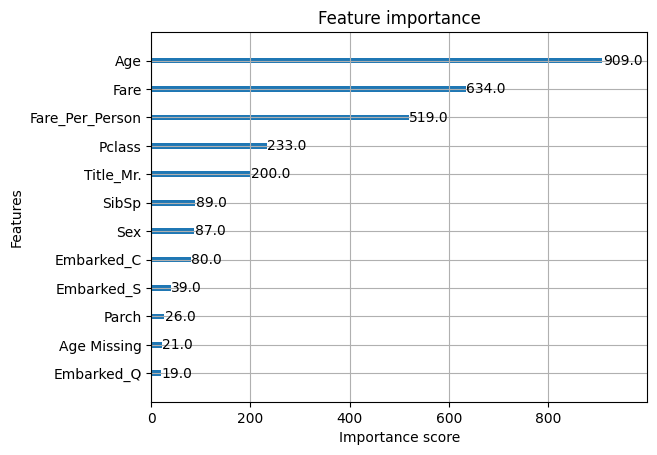

In [220]:
xgb.plot_importance(best_xgb_model, max_num_features = len(train_df.columns))

# Light GBM

In [302]:

lgb_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    random_state=42
)
lgb_model.fit(X_train, y_train)


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,4
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [313]:
y_pred = lgb_model.predict(X_val)
accuracy_score(y_pred, y_val)

0.8715083798882681

# Submission

In [225]:
MODEL_CHOICE = best_xgb_model

In [226]:
VERSION = '_v4_xgb'

In [227]:
test_features = test_df[features]

In [228]:
submission = pd.DataFrame({
    'PassengerId': test_df['PassengerId'],
    'Survived': MODEL_CHOICE.predict(test_features)
})
submission.to_csv('submission' + VERSION + '.csv', index=False)